<a href="https://colab.research.google.com/github/SebastianWikt/DS4002-P1/blob/main/Project_1_text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importance of Word Choice in Education

### Group 5: Neha Channamraju (leader), Sebastian Wiktorowicz, Catherine Young

In [ ]:
#ONLY NEED TO RUN THIS ONE TIME
!pip install nltk
!pip install spacy
!pip install scikit-learn
!pip install textblob
!pip install wordcloud
!pip install pandas numpy matplotlib seaborn

#Install spacy extra data
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!rm -r DS4002-P1/

In [1]:
! git clone https://github.com/SebastianWikt/DS4002-P1.git

Cloning into 'DS4002-P1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
Receiving objects: 100% (40/40), 94.52 KiB | 921.00 KiB/s, done.
remote: Total 40 (delta 22), reused 0 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (22/22), done.


In [2]:
from typing_extensions import dataclass_transform
import os # to run file I/O operation
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import re
import string
import datetime
from wordcloud import WordCloud
from textblob import TextBlob
import spacy
from collections import Counter
np.random.seed(42)

# Download necessary NLTK data
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

# Load English tokenizer, tagger, parser, NER, and word vectors from spacy
nlp = spacy.load('en_core_web_sm')

def loadData(file):
  # The column names are adopted from the dataset page on Kaggle
  df = pd.read_csv(file)
  return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data = pd.read_csv('/content/DS4002-P1/project_1_dataset.csv')
data = data.rename(columns={"Unnamed: 42": "no_of_words"})

In [4]:
print(data.columns)

Index(['Rank in 2020', 'Rank in 2019', 'Rank in 2018', '3 year average rank',
       'School name', 'Country', 'Audit year', 'Salary today (US$)',
       'Weighted salary (US$)', 'Salary percentage increase',
       'Value for money rank', 'Career progress rank', 'Aims achieved (%)',
       'Careers service rank', 'Employed at three months (%)',
       'Alumni recommend rank', 'Female faculty (%)', 'Female students (%)',
       'Women on board (%)', 'International faculty (%)',
       'International students (%)', 'International board (%)',
       'International mobility rank', 'International course experience rank',
       'Languages', 'Faculty with doctorates (%)', 'FT research rank',
       'CSR rank', 'Unnamed: 28', 'Value statement', 'No. of words', 'Clear',
       'Realistic', 'Shorter', 'Easy to communicate', 'Easy to memorize',
       'Easy to be explained', 'Focused', 'Unique', 'Decision Making guidance',
       'Challenging', 'Mission Statements', 'no_of_words', 'Customers',


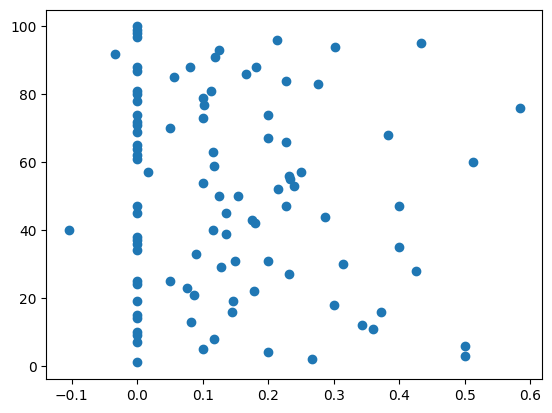

In [5]:
# Import the TextBlob library
from textblob import TextBlob

# Define a function to calculate the polarity and subjectivity of a text
def get_sentiment(text):
	blob = TextBlob(text)
	return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the function to the reviews
data['polarity'], data['subjectivity'] = zip(*data['Mission Statements'].astype(str).map(get_sentiment))

# Display the first few rows of the dataframe
plt.scatter(data['polarity'], data['Rank in 2020'])
plt.show()

In [ ]:
# from nltk.sentiment import SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()
# sia.polarity_scores("Wow, NLTK is really powerful!")

In [6]:
def scatterAndLine(x, y):
    a, b = np.polyfit(x, y, 1)

    #add points to plot
    plt.scatter(x, y)

    #add line of best fit to plot
    plt.plot(x, a*x+b)

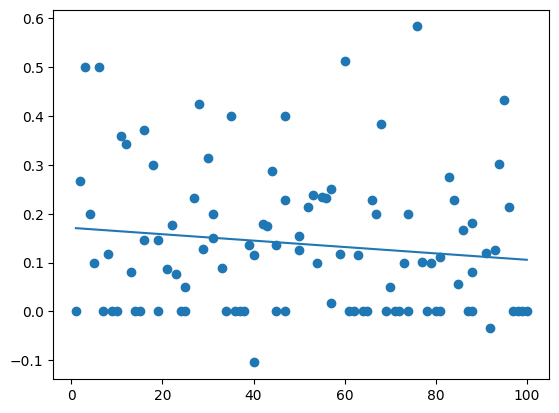

In [7]:
scatterAndLine(data['Rank in 2020'], data['polarity'])

<Axes: xlabel='no_of_words', ylabel='Rank in 2020'>

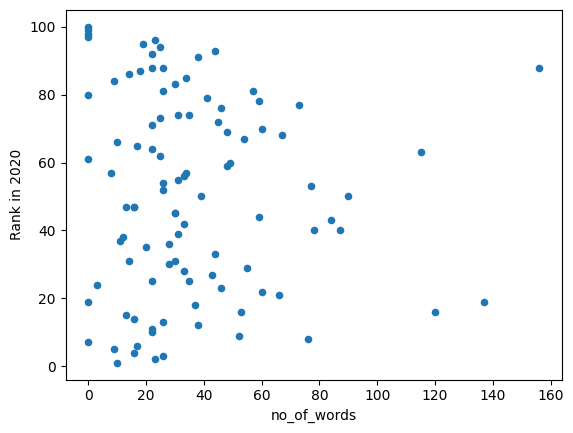

In [8]:
# Plotting word length and ranking in 2020
lrank = data[['Rank in 2020', 'no_of_words']]
lrank.plot(kind='scatter', x='no_of_words', y='Rank in 2020')

In [28]:
def printRandP(data, column_name, compare_column, table):
  r_value, p_value = pointbiserialr(data[column_name], data[compare_column])
  scatterAndLine(data[column_name], data[compare_column])
  new_row = pd.DataFrame({"Variable": [column_name], "r_value": [r_value], "p_value": [p_value]})
    # Create or update the table
  if table is None or table.empty:
      table = new_row
  else:
      # Concatenate the new row to the existing table
      table = pd.concat([table, new_row], ignore_index=True)

  table = table.drop_duplicates(subset=["Variable", "r_value", "p_value"], keep="first")

  print(f"Point-biserial correlation coefficient: {r_value}")
  print(f"P-value: {p_value}")
  return table

Point-biserial correlation coefficient: -0.11348864999864991
P-value: 0.2609049463384916
Point-biserial correlation coefficient: -0.10169093474792448
P-value: 0.3140612106149365
Point-biserial correlation coefficient: -0.08918324608842382
P-value: 0.3775713956276628
Point-biserial correlation coefficient: -0.21212755257020796
P-value: 0.034108893467715416
Point-biserial correlation coefficient: -0.08092479420255176
P-value: 0.42348626121668187
Point-biserial correlation coefficient: -0.07464916156389984
P-value: 0.46043112317453955
Point-biserial correlation coefficient: -0.022245187826176425
P-value: 0.8261186071660203
                 Variable   r_value   p_value
0             Realistic_b -0.113489  0.260905
1               Shorter_b -0.101691  0.314061
2   Easy to communicate_b -0.089183  0.377571
3      Easy to memorize_b -0.212128  0.034109
4  Easy to be explained_b -0.080925  0.423486
5               Focused_b -0.074649  0.460431
6                Unique_b -0.022245  0.826119


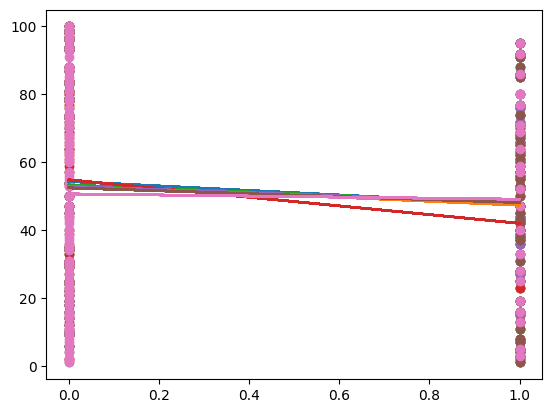

In [31]:
from scipy.stats import pointbiserialr

# Convert the 'Yes'/'No' column to numerical values (Yes=1, No=0)
      #  'Realistic', 'Shorter', 'Easy to communicate', 'Easy to memorize',
      #  'Easy to be explained', 'Focused', 'Unique',
data['Realistic_b'] = data['Realistic'].apply(lambda x: 1 if x == 'Y' else 0)
data['Shorter_b'] = data['Shorter'].apply(lambda x: 1 if x == 'Y' else 0)
data['Easy to communicate_b'] = data['Easy to communicate'].apply(lambda x: 1 if x == 'Y' else 0)
data['Easy to memorize_b'] = data['Easy to memorize'].apply(lambda x: 1 if x == 'Y' else 0)
data['Easy to be explained_b'] = data['Easy to be explained'].apply(lambda x: 1 if x == 'Y' else 0)
data['Focused_b'] = data['Focused'].apply(lambda x: 1 if x == 'Y' else 0)
data['Unique_b'] = data['Unique'].apply(lambda x: 1 if x == 'Y' else 0)

table = None
table = printRandP(data, 'Realistic_b', 'Rank in 2020', table)
table = printRandP(data, 'Shorter_b', 'Rank in 2020', table)
table = printRandP(data, 'Easy to communicate_b', 'Rank in 2020', table)
table = printRandP(data, 'Easy to memorize_b', 'Rank in 2020', table)
table = printRandP(data, 'Easy to be explained_b', 'Rank in 2020', table)
table = printRandP(data, 'Focused_b', 'Rank in 2020', table)
table = printRandP(data, 'Unique_b', 'Rank in 2020', table)

print(table)


# Calculate the point-biserial correlation between the binary column and the 'Rank in 2020'
# print(data['Realistic_b'])